# STROKE PROBABILITY MODEL - DATA EXPLORATION

## IMPORT LIBRARIES


In [40]:
# Importing class
from collections import Counter
from imblearn.over_sampling import SMOTE
from math import sqrt
from matplotlib import pyplot
from numpy import where
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve, classification_report, auc, f1_score, r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report,plot_roc_curve, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import logit
import imblearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
pd.pandas.set_option('display.max_columns',None)
print(imblearn.__version__)



0.8.0


## IMPORT DATA FILE & EXPLORE DETAILS

In [41]:
#CHANCE OF STROKE - change 'Unknown' data in Smoking_status to N/A
stroke=pd.read_csv(r'C:\Users\tfuji\Documents\SpringBoard\Capstone\Stroke_Data_Raw.csv',header=0, na_values={'smoking_status':'Unknown'})

print('\033[1m'+"Stroke Variables:"+'\033[0m')
print(stroke.columns.values)
print()
print()
print('\033[1m'+"DateFrame Shape:"+'\033[0m')
print((stroke.shape))
print()

#Data Info
print('\033[1m'+'INSIGHT: VARIABLE TYPE'+'\033[0m') 
print('2 qty -  Nominal: Work_Type, Smoking_Status')
print('6 qty -  Binary: Gender, Residence_type, Hypertension, Heart_Disease, Ever_Married, Stroke')
print('3 qty - Continuous: Age, Avg_Glucose_Level, BMI')
print()



# Null Values Total
print('\033[1m'+"Null Totals"+'\033[0m')
print(stroke.isna().sum())
print()



Stroke Variables:
['id' 'gender' 'age' 'hypertension' 'heart_disease' 'ever_married'
 'work_type' 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status'
 'stroke']


DateFrame Shape:
(5110, 12)

INSIGHT: VARIABLE TYPE
2 qty -  Nominal: Work_Type, Smoking_Status
6 qty -  Binary: Gender, Residence_type, Hypertension, Heart_Disease, Ever_Married, Stroke
3 qty - Continuous: Age, Avg_Glucose_Level, BMI

Null Totals
id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1544
stroke                  0
dtype: int64



# 1. DATA CLEANSING

## 1.1 MISSING VALUES: Deleting and Filling-In

In [42]:
#DELETE: Null Smoking_Status
stroke_3=stroke.dropna(subset =['smoking_status'])


#FILL NA: Null BMI
bmi_med=stroke_3['bmi'].median()
stroke_med=stroke_3.fillna(bmi_med)

# DELETE: Single gender "Other" Observation due to sample size
stroke_med=stroke_med[stroke_med['gender'].str.contains("Other")==False]

#SUMMARY: find % of missing values per column with missing values
#Shape after Null Smoking deleted
print('\033[1m'+"Shape: No Null Values"+'\033[0m')
print("-The shape of the modified DataFrame is {}".format(stroke_med.shape))


Shape: No Null Values
-The shape of the modified DataFrame is (3565, 12)


## 1.2 CONVERTING: Binary variables to 1/0

In [43]:
# Convert ever_married Yes/No to 1/0
## 1=Yes, 0=No
stroke_med['ever_married']=stroke_med['ever_married'].replace(['Yes','No'],[1,0])

# Convert Residence_type Yes/No to 1/0
## 1=Urban, 0=Rural
stroke_med['Residence_type']=stroke_med['Residence_type'].replace(['Urban','Rural'],[1,0])

# Convert gender Male/Female to 1/0
## 1=Male, 0=Female
stroke_med['gender']=stroke_med['gender'].replace(['Male','Female'],[1,0])


## 1.3 REVIEW: Variables and Values

In [44]:
# Listing all unique values per variable.
print('\033[1m'+"Qualitative Column Values:"+'\033[0m')
for col in nominal:
    x=nominal[nominal['stroke']==1]
    z=(str(col)+" - "+(str(x[col].unique())))
    print(z)
print()
print('\033[1m'+"Quantitative Column Values:"+'\033[0m')
print("age")
print("avg_glucose_level")
print("bmi")

Qualitative Column Values:
gender - [1 0]
hypertension - [0 1]
heart_disease - [1 0]
ever_married - [1 0]
work_type - ['Private' 'Self-employed' 'Govt_job']
Residence_type - [1 0]
smoking_status - ['formerly smoked' 'never smoked' 'smokes']
stroke - [1]

Quantitative Column Values:
age
avg_glucose_level
bmi


### INSIGHTS: DATA CLEANSING
#### 1. Raw DataFrame has 5110 observations(rows) and 12 variables(columns). 
    5 qty -  Nominal: Gender, Work_Type, Residence_Type, Smoking_Status
    4 qty -  Binary: Hypertension, Heart_Disease, Ever_Married, Stroke
    3 qty - Continuous: Age, Avg_Glucose_Level, BMI
#### 2. Missing values: 
     smoking_status: 1544 (30.22%) - All deleted
     bmi(raw data): 201 (3.93%) 
     bmi(after smoking deleted): 140 (4.0864%) - All replaced with bmi median value
#### 3. DataFrame Shape:
    Raw: The shape of the raw DataFrame was (5110, 12)
    Modified: The shape of the modified DataFrame is (3566, 12)
#### 4. DataFrame Variables and Values:
    Qualitative Column Values:
    gender - ['Male' 'Female' 'Other']
    hypertension - [0 1]
    heart_disease - [1 0]
    ever_married - ['Yes' 'No']
    work_type - ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
    Residence_type - ['Urban' 'Rural']
    smoking_status - ['formerly smoked' 'never smoked' 'smokes']
    stroke - [1 0]

    Quantitative Column Values:
    age
    avg_glucose_level
    bmi

### FOR REFERENCE: Modified DataFrames

In [45]:
stroke_yes = stroke_med[stroke_med['stroke']==1]
stroke_no = stroke_med[stroke_med['stroke']==0]

# Quan = only continuous variables
quan = stroke_med[['age','avg_glucose_level','bmi','stroke']]

# Quan_labels_only = continuous(Quan) - Stroke
quan_labels_only=stroke_med.drop(['id', 'gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type','smoking_status', 'stroke'],axis=1).columns

#Nominal= Binary + (Gender, Work Type, Smoking_status)
nominal=stroke_med[['gender','hypertension','heart_disease','ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']]

#Binary = stroke_med - quan & (Gender, Work Type, Smoking_status)
binary=stroke_med[['gender','hypertension','heart_disease','ever_married','Residence_type','stroke']]
stroke_nominal=nominal[nominal['stroke'] == 1]


# 2. DATA EXPLORATION

## 2.1 DEPENDENT VARIABLE

0    3363
1     202
Name: stroke, dtype: int64

percentage of no stroke is 94.334%
percentage of stroke 5.666%



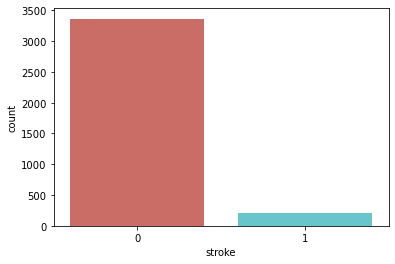

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi
stroke,,,,,,,,,
0,36793.457032,0.392804,47.700565,0.114184,0.056200,0.752007,0.507880,107.448379,30.231282
1,36561.559406,0.425743,68.168317,0.306931,0.193069,0.896040,0.524752,134.344653,30.482673


In [28]:
#Explore Stroke vs Non Stroke Distribution
print(stroke_med['stroke'].value_counts())
print()


count_no_stroke = len(stroke_med[stroke_med['stroke']==0])
count_stroke = len(stroke_med[stroke_med['stroke']==1])

pct_of_no_stroke = count_no_stroke/(count_no_stroke+count_stroke)
print("percentage of no stroke is {}%".format( round((pct_of_no_stroke*100),3)))

pct_of_stroke = count_stroke/(count_no_stroke+count_stroke)
print("percentage of stroke {}%".format(round((pct_of_stroke*100),3)))
print()


sns.countplot(x='stroke',data=stroke_med, palette = 'hls')
plt.show()


# Observing differences in mean for independent variables
stroke_med.groupby('stroke').mean()

#### INSIGHT: DATA SET DISTRIBUTION IS NOT BALANCED

## 2.2 QUANTITATIVE VARIABLES - Change in Median - Stroke vs Non-Stroke

In [260]:
def median_comp(df,col):
        stroke1=df[(df['stroke'] == 1)]
        stroke0=df[(df['stroke'] == 0)]
        print("The median {} for stroke patients is {}.".format(col,round((stroke1[col].median()),2)))
        print("The median {} for non-stroke patients is {}.".format(col,stroke0[col].median()))
        print("The median {} increase due to stroke is {} or {}%".format(col,round((stroke1[col].median())-(stroke0[col].median()),2),round((((stroke1[col].median())-(stroke0[col].median()))/(stroke0[col].median()))*100,2)))
        return
for col in quan.iloc[:,:-1]:
    x=(median_comp(stroke_med,col))
    print()

The median age for stroke patients is 71.0.
The median age for non-stroke patients is 48.0.
The median age increase due to stroke is 23.0 or 47.92%

The median avg_glucose_level for stroke patients is 106.57.
The median avg_glucose_level for non-stroke patients is 92.06.
The median avg_glucose_level increase due to stroke is 14.51 or 15.77%

The median bmi for stroke patients is 29.1.
The median bmi for non-stroke patients is 29.1.
The median bmi increase due to stroke is 0.0 or 0.0%



#### INSIGHT: Of the 3 continuous variables, Age and Average Glucose Level's medians saw significant increases from non-stroke to stroke patients.  The median Age increased the most at 47.92%, Average Glucose Levels increased 2nd most at 15.75%, and BMI saw no increase.

## 2.3 Quantiles, Outliers and Boxplots

In [516]:
def box_and_quartiles(quan_df,col):
#for col in quan.iloc[:,0:3]:
    #Dataframe for Plot Loops(with column)
    cont_1=quan_df[quan_df['stroke'] == 1][col]
    cont_0=quan_df[quan_df['stroke'] == 0][col]
    
    #Plot Loop
    data = [cont_1,cont_0]
    fig = plt.figure(figsize =(10, 7)) 
    ax = fig.add_axes([0, 0, 1, 1]) 
    bp = ax.boxplot(data) 
    plt.title(col+' vs. Stroke', fontsize=38)  
    ax.set_xlabel("STROKE                                         NON-STROKE", fontsize=20)
    ax.set_ylabel(col, fontsize=20)

    plt.show() 
 
    #positionalize
    
    #Dataframe for Quartile Summary(No Column)
    cont_1_1=quan_df[quan_df['stroke'] == 1]
    cont_0_0=quan_df[quan_df['stroke'] == 0]
    
    #Summary for Stroke Patients
    print('\033[1m'+str(col)+'\033[0m')
    print('\033[1m'+"Stroke Patients:"+'\033[0m')
    
    #Stroke Quartiles
    q1=(cont_1_1[col].quantile(.25))
    q2=(cont_1_1[col].quantile(.50))
    q3=(cont_1_1[col].quantile(.75))
    iqr=q3-q1
    
    #Stroke Non Outliers
    df_not_ol =cont_1_1[~((cont_1_1[col] < (q1 - 1.5 * iqr)) |(cont_1_1[col] > (q3 + 1.5* iqr)))]
    num_non_outliers = len(df_not_ol[col])
    total_count = len(cont_1_1[col])
    num_outliers = total_count-num_non_outliers
    perc_ol=round(((1 - (num_non_outliers/total_count))*100),2)
    
    print("Outliers: "+str(num_outliers))
    print("Non Outliers: "+str(num_non_outliers))
    print("Total Count: "+str(total_count))
    print("Percent Outliers: "+str(round(perc_ol,2))+"%")
    print("IQR: "+str(round(iqr,2)))
    print("Upper Limit: "+str(round((q3+(1.5*iqr)),2)))
    print("Max: "+str(cont_1_1[col].max()))
    print("q3: "+str(round(q3,2)))
    print("q2: "+str(round(q2,2)))
    print("q1: "+str(round(q1,2)))
    print("Min: "+str(cont_1_1[col].min()))
    print("Lower Limit: "+str(round((q1-1.5*iqr),2)))
    print()
    
    #Summary for Non-Stroke Patients
    print('\033[1m'+str(col)+'\033[0m')
    print('\033[1m'+"Non-Stroke Patients:"+'\033[0m')
    
    #Non Stroke Quartiles
    q10=(cont_0_0[col].quantile(.25))
    q20=(cont_0_0[col].quantile(.50))
    q30=(cont_0_0[col].quantile(.75))
    iqr0=q30-q10
    
    #Non Stroke Non Outliers
    df_not_ol0 =cont_0_0[~((cont_0_0[col] < (q10 - 1.5 * iqr0)) |(cont_0_0[col] > (q30 + 1.5* iqr0)))]
    num_non_outliers0 = len(df_not_ol0[col])
    total_count0 = len(cont_0_0[col])
    num_outliers0 = total_count0-num_non_outliers0
    perc_ol0=round(((1 - (num_non_outliers0/total_count0))*100),2)
    
    print("Outliers: "+str(num_outliers0))
    print("Non Outliers: "+str(num_non_outliers0))
    print("Total Count: "+str(total_count0))
    print("Percent Outliers: "+str(perc_ol0)+"%")
    print("IQR: "+str(round(iqr0,2)))
    print("Upper Limit: "+str(q30+(1.5*iqr0)))
    print("Max: "+str(cont_0_0[col].max()))
    print("q3: "+str(q30))
    print("q2: "+str(q20))
    print("q1: "+str(q10))
    print("Min: "+str(cont_0_0[col].min()))
    print("Lower Limit: "+str(round((q10-1.5*iqr0),2)))
    print()
    print()    
    print()

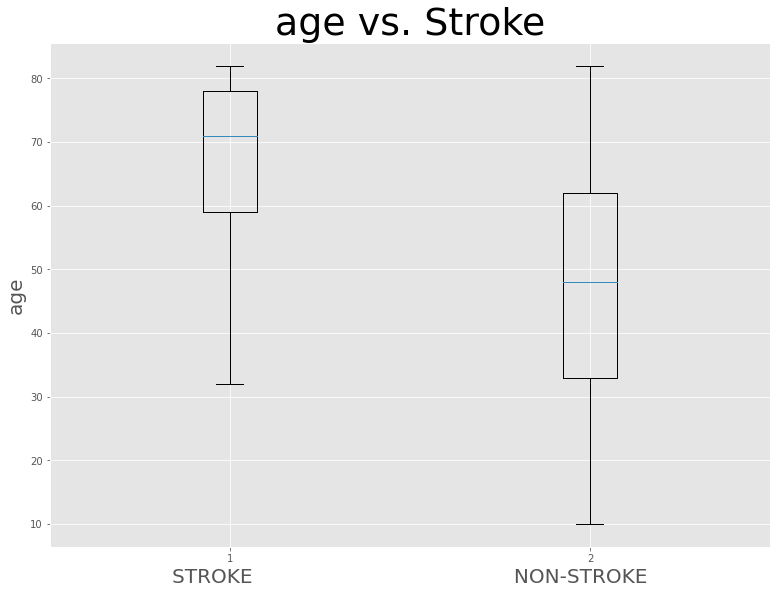

age
Stroke Patients:
Outliers: 0
Non Outliers: 202
Total Count: 202
Percent Outliers: 0.0%
IQR: 19.0
Upper Limit: 106.5
Max: 82.0
q3: 78.0
q2: 71.0
q1: 59.0
Min: 32.0
Lower Limit: 30.5

age
Non-Stroke Patients:
Outliers: 0
Non Outliers: 3364
Total Count: 3364
Percent Outliers: 0.0%
IQR: 29.0
Upper Limit: 105.5
Max: 82.0
q3: 62.0
q2: 48.0
q11: 33.0
Min: 10.0
Lower Limit: -10.5





In [515]:
box_and_quartiles(quan,'age')

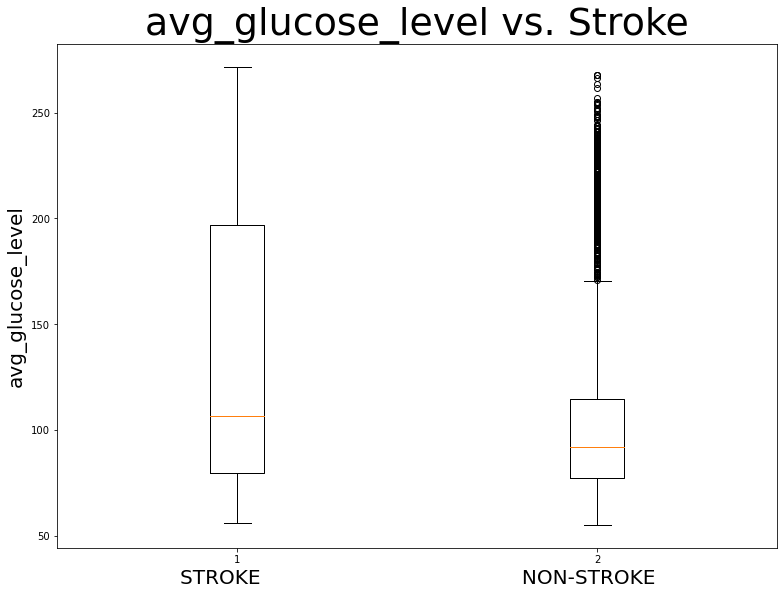

avg_glucose_level
Stroke Patients:
Outliers: 0
Non Outliers: 202
Total Count: 202
Percent Outliers: 0.0%
IQR: 116.99
Upper Limit: 372.36
Max: 271.74
q3: 196.87
q2: 106.57
q1: 79.88
Min: 56.11
Lower Limit: -95.61

avg_glucose_level
Non-Stroke Patients:
Outliers: 448
Non Outliers: 2916
Total Count: 3364
Percent Outliers: 13.32%
IQR: 37.22
Upper Limit: 170.38750000000002
Max: 267.76
q3: 114.5575
q2: 92.07
q1: 77.33749999999999
Min: 55.12
Lower Limit: 21.51





In [79]:
box_and_quartiles(quan,'avg_glucose_level')

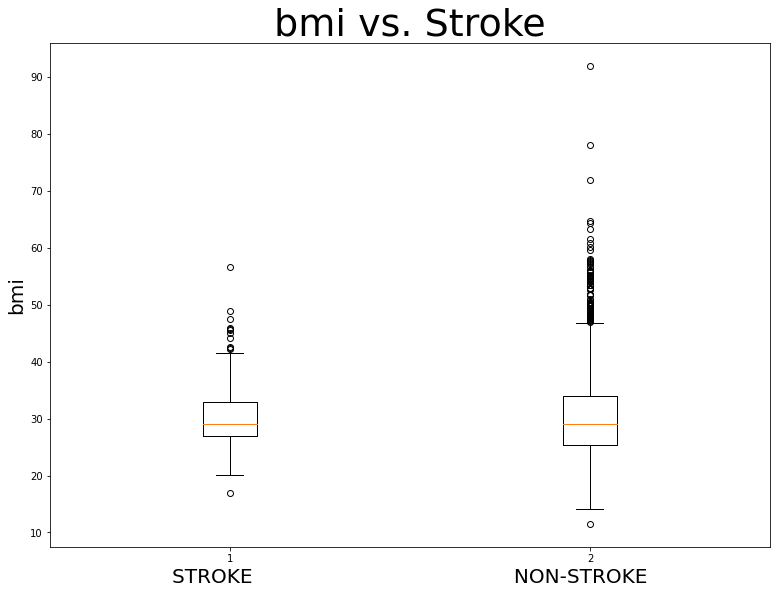

bmi
Stroke Patients:
Outliers: 12
Non Outliers: 190
Total Count: 202
Percent Outliers: 5.94%
IQR: 5.95
Upper Limit: 41.9
Max: 56.6
q3: 32.98
q2: 29.1
q1: 27.02
Min: 16.9
Lower Limit: 18.1

bmi
Non-Stroke Patients:
Outliers: 91
Non Outliers: 3273
Total Count: 3364
Percent Outliers: 2.71%
IQR: 8.6
Upper Limit: 46.8
Max: 92.0
q3: 33.9
q2: 29.1
q1: 25.3
Min: 11.5
Lower Limit: 12.4





In [80]:
box_and_quartiles(quan,'bmi')

## 2.4 Stroke Totals per Value

In [43]:
# TOTAL STROKE OBSERVATIONS PER GROUPED VALUES - CONTINUOUS VARIABLES ONLY
def raw_cont_count(cont_df,col):
    if col != 'stroke':
        age_sum=cont_df[[col,'stroke']].loc[cont_df['stroke']==1].groupby([col]).count()
        age_sum.plot(kind='bar',figsize=(15,6))
        plt.tight_layout()


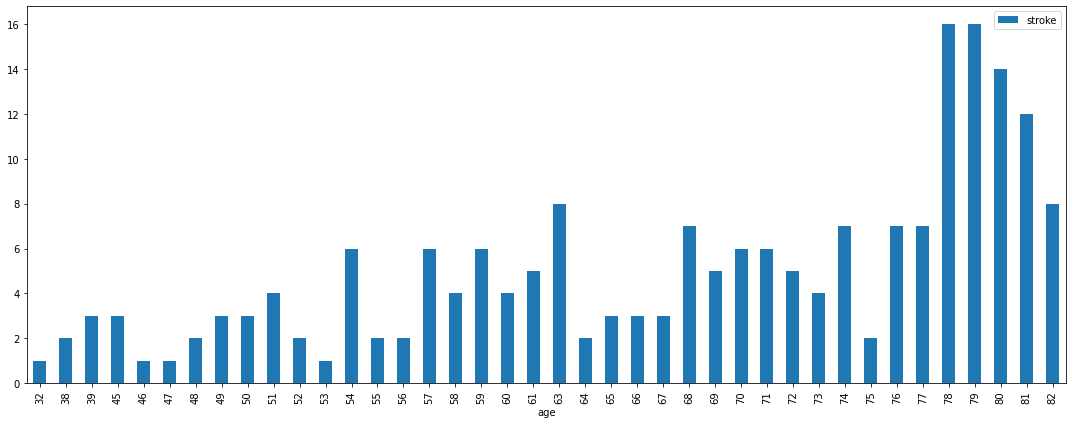

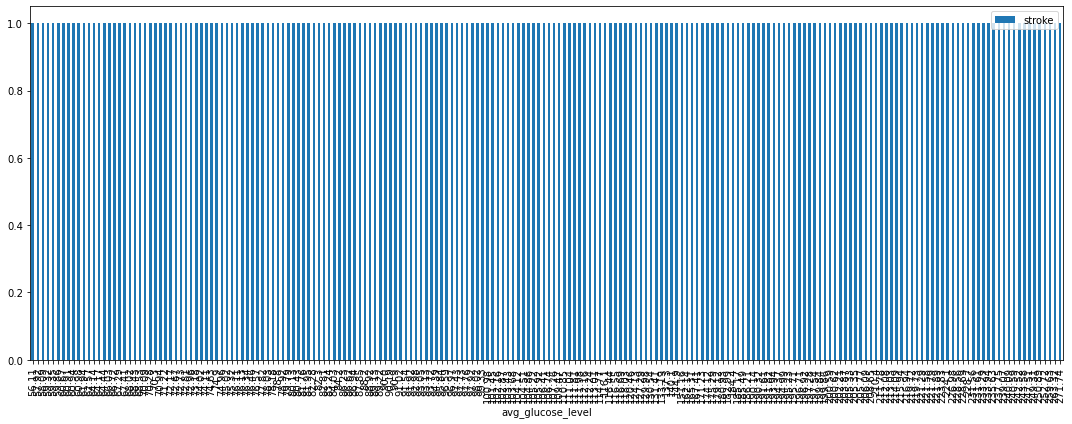

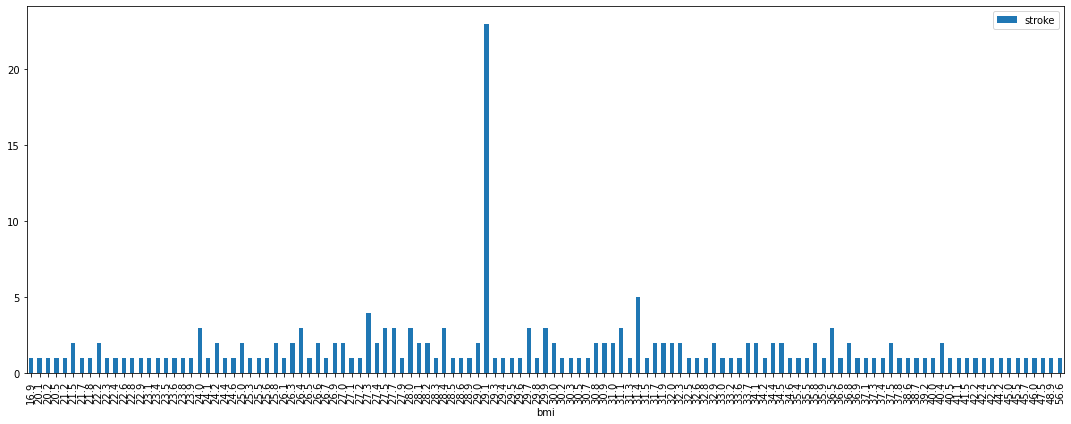

In [44]:
raw_cont_count(quan,'age')
raw_cont_count(quan,'avg_glucose_level')
raw_cont_count(quan,'bmi')

#### INSIGHT: Need Bin Transformation

## 2.5.A BIN TRANSFORMATION: Stroke Frequency per Bin - BAR GRAPH OPTION 2

In [59]:
# Defining bins for each continuous variable, and adding a 'bin' column to dataframe
quan_bin=quan.copy()

# () inclusive, [] exclusive

age_bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110]
quan_bin['age_bin']=pd.cut(stroke_med['age'],age_bins)

glucose_bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300]
quan_bin['glu_bin']=pd.cut(stroke_med['avg_glucose_level'],glucose_bins)


bmi_bins=[0,5,10,15,20,25,30,35,40,45,50]
quan_bin['bmi_bin']=pd.cut(stroke_med['bmi'],bmi_bins)

quan_bin1=quan_bin[(quan_bin['stroke']==1)]
quan_bin0=quan_bin[(quan_bin['stroke']==0)]


#LOOP VERSION: printing count for each specific bin for continuous variable
#NOTE: No 
for col in quan_bin1.iloc[:,4:]:
    quan_bin1_agg = quan_bin1[[col,'stroke']].groupby(quan_bin1[col]).count()
    quan_bin0_agg=quan_bin0[[col,'stroke']].groupby(quan_bin0[col]).count()
    print("STROKE Count per: {}".format(col))
    print(quan_bin1_agg.iloc[:,0])
    print()
    print("NON-STROKE Count per: {}".format(col))
    print(quan_bin0_agg.iloc[:,0])
    print()
    print()
    print()
# df.set_index(age_bins)  
# return: df[]/total

quan_bin1_agg.iloc[:,0:1]

STROKE Count per: age_bin
age_bin
(0, 5]         0
(5, 10]        0
(10, 15]       0
(15, 20]       0
(20, 25]       0
(25, 30]       0
(30, 35]       1
(35, 40]       5
(40, 45]       3
(45, 50]      10
(50, 55]      15
(55, 60]      22
(60, 65]      18
(65, 70]      24
(70, 75]      24
(75, 80]      60
(80, 85]      20
(85, 90]       0
(90, 95]       0
(95, 100]      0
(100, 105]     0
(105, 110]     0
Name: age_bin, dtype: int64

NON-STROKE Count per: age_bin
age_bin
(0, 5]          0
(5, 10]        10
(10, 15]       99
(15, 20]      171
(20, 25]      210
(25, 30]      220
(30, 35]      260
(35, 40]      270
(40, 45]      289
(45, 50]      286
(50, 55]      344
(55, 60]      289
(60, 65]      258
(65, 70]      190
(70, 75]      179
(75, 80]      214
(80, 85]       74
(85, 90]        0
(90, 95]        0
(95, 100]       0
(100, 105]      0
(105, 110]      0
Name: age_bin, dtype: int64



STROKE Count per: glu_bin
glu_bin
(0, 10]        0
(10, 20]       0
(20, 30]       0
(30, 40]     

,bmi_bin
bmi_bin,
"(0, 5]",0
"(5, 10]",0
"(10, 15]",0
"(15, 20]",1
"(20, 25]",31
"(25, 30]",86
"(30, 35]",46
"(35, 40]",22
"(40, 45]",10


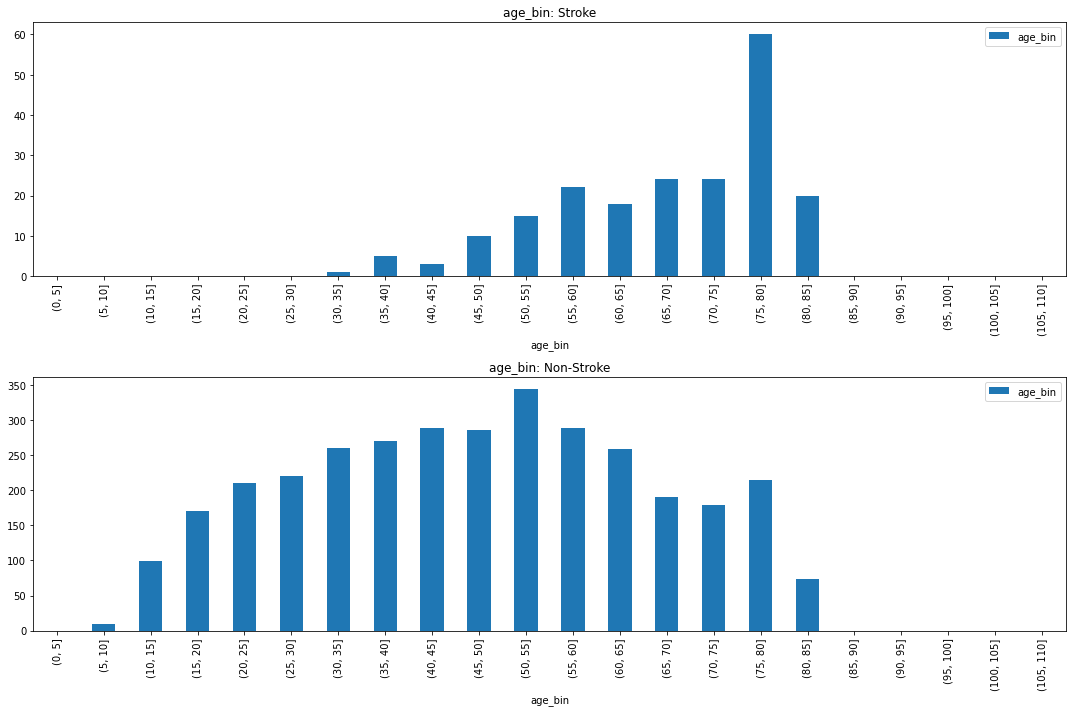

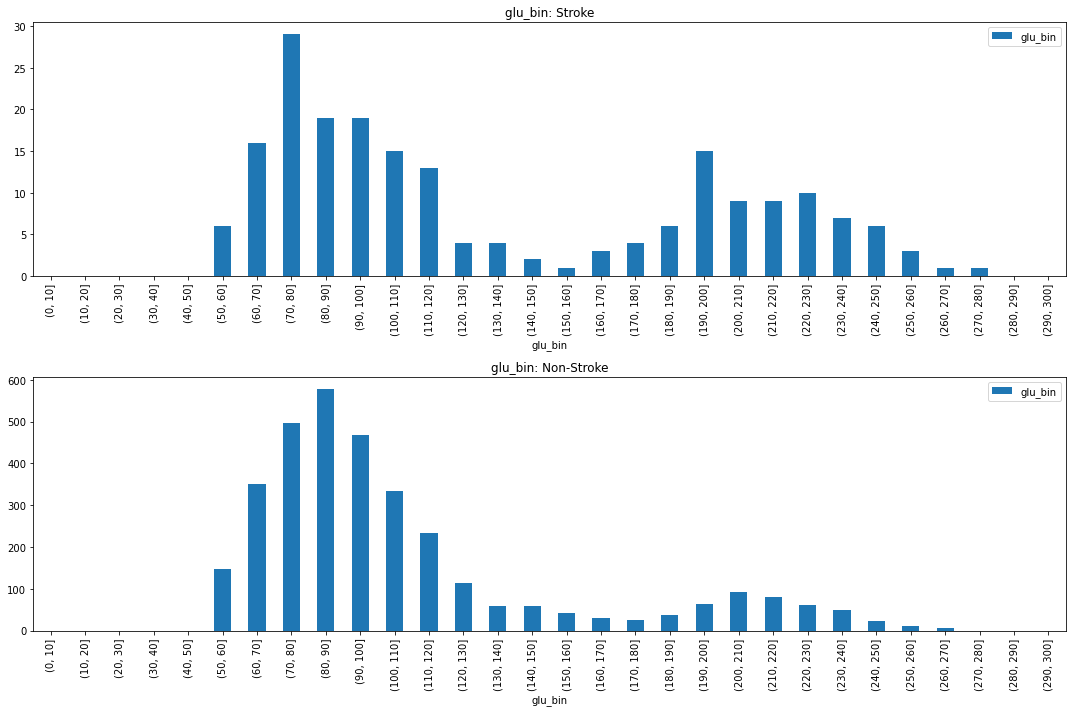

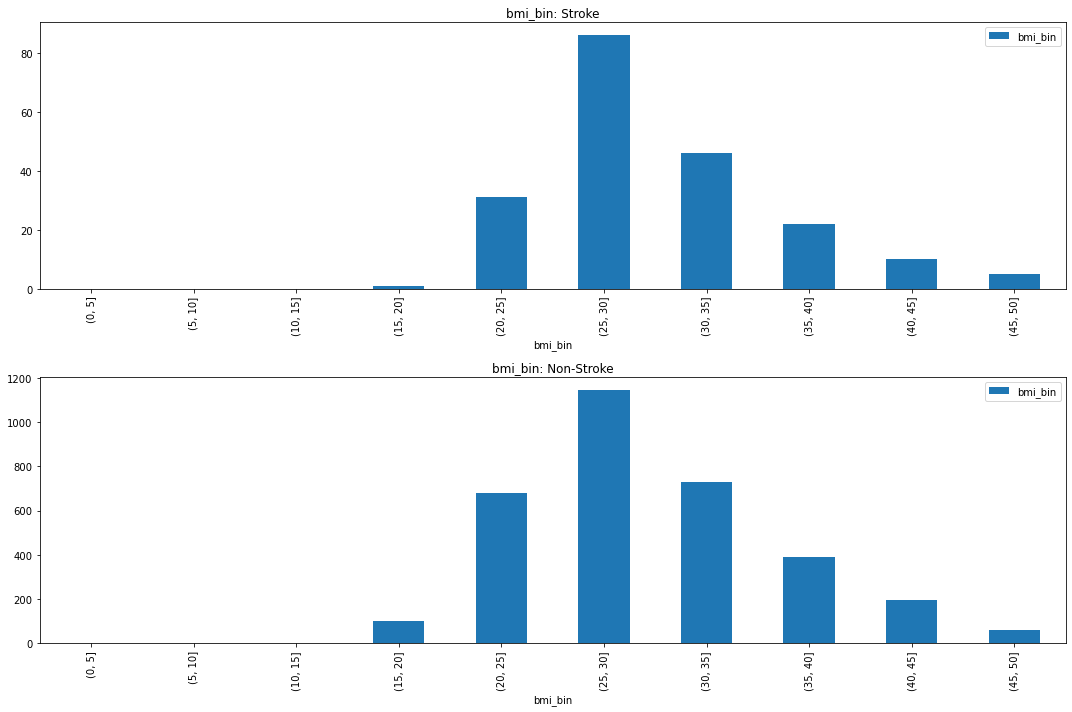

In [62]:
#BAR GRAPH FOR CONTINUOUS BINS: STROKE vs NON STROKE
# NEED HELP: adding title to each
for col in quan_bin1.iloc[:,4:]:
    quan_bin1_agg=quan_bin1[[col,'stroke']].groupby(quan_bin1[col]).count()
    quan_bin0_agg=quan_bin0[[col,'stroke']].groupby(quan_bin0[col]).count() 
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    ax1=quan_bin1_agg.iloc[:,0:1].plot(kind='bar',ax=axes[0], figsize=(15,10))
    ax1.title.set_text("{}: Stroke".format(col))
    ax2=quan_bin0_agg.iloc[:,0:1].plot(kind='bar',ax=axes[1], figsize=(15,10))
    ax2.title.set_text("{}: Non-Stroke".format(col))
    plt.tight_layout()
    print()
    print()
    print()
    print()
    print()
    print()
    

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax1=quan_bin1_agg.iloc[:,0:1].plot(kind='bar',ax=axes[0], figsize=(15,10))
ax1.title.set_text("{}: Stroke".format(col))
ax2=quan_bin0_agg.iloc[:,0:1].plot(kind='bar',ax=axes[1], figsize=(15,10))
ax2.title.set_text("{}: Non-Stroke".format(col))
plt.tight_layout()

In [58]:
print(quan_bin0_agg)

          bmi_bin  stroke
bmi_bin                  
(0, 5]          0       0
(5, 10]         0       0
(10, 15]        3       3
(15, 20]      103     103
(20, 25]      678     678
(25, 30]     1147    1147
(30, 35]      728     728
(35, 40]      390     390
(40, 45]      198     198
(45, 50]       59      59


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax1=df.plot(kind='bar',ax=axes[0], figsize=(15,10))
ax1.title.set_text("")
ax2=df.plot(kind='bar',ax=axes[1], figsize=(15,10))
ax2.title.set_text("")
plt.tight_layout()

## 2.5.B BIN TRANSFORMATION: Stroke Frequency per Bin Seaborn Histogram (Option 2)

In [173]:
# plotting bins using Seaborn Histogram function
def quan_hist(df,col):
    yes=df[df['stroke']==1]
    no=df[df['stroke']==0]
    plt.figure(figsize = (12, 6))
    _=plt.hist(yes[col], bins=20)
    _=plt.xlabel(col,fontsize=20)
    _=plt.ylabel('Stroke Frequency', fontsize=20)
    plt.figure(figsize = (12, 6))
    _=plt.hist(no[col], bins=20)
    _=plt.xlabel(col,fontsize=20)
    _=plt.ylabel('Non-Stroke Frequency',fontsize=20)
    print()
    print()
    print()
    print()
    print()
    print()



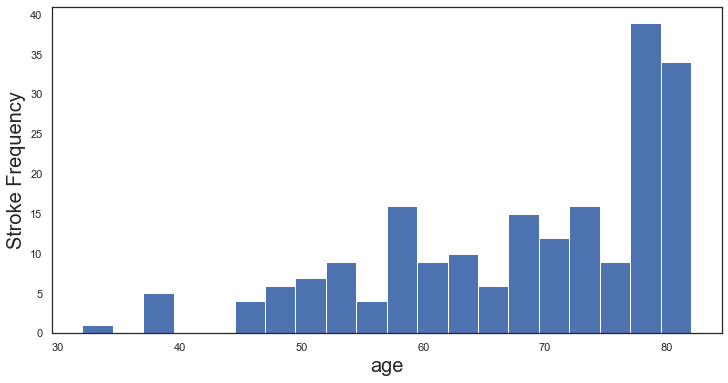

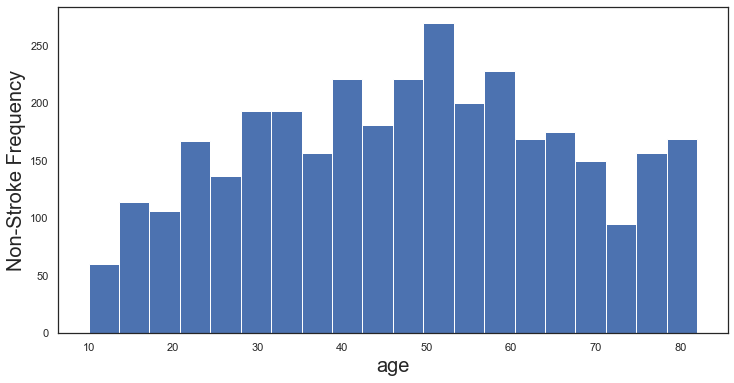

In [174]:
quan_hist(stroke_med,'age')

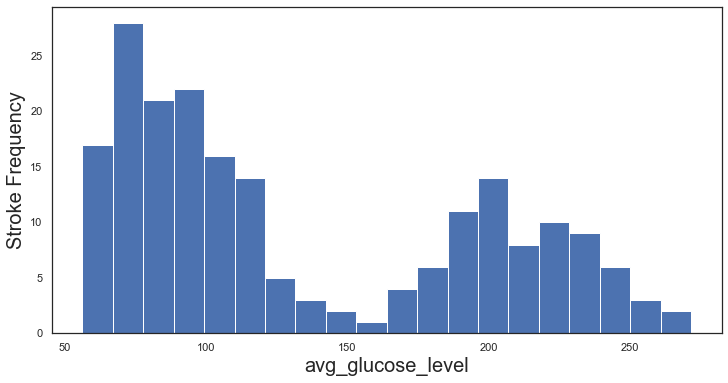

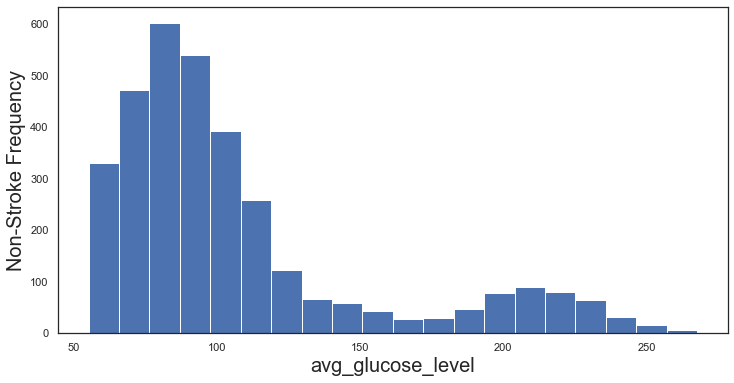

In [175]:
quan_hist(stroke_med,'avg_glucose_level')

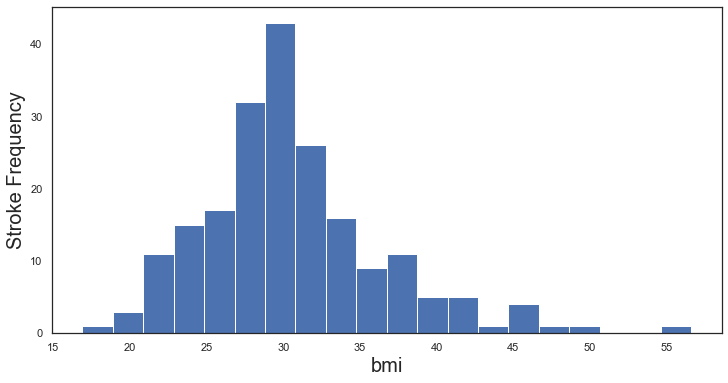

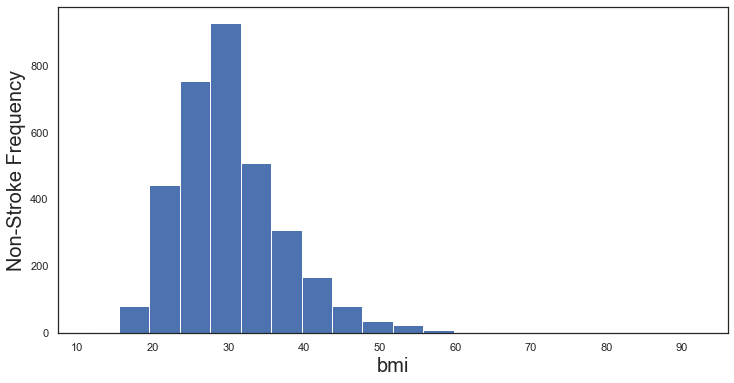

In [176]:
quan_hist(stroke_med,'bmi')

## 2.6 BINOMIAL VARIABLES - Bar Chart

In [177]:

def bar_proportions(df, col):
    
    # Totals
    print("Totals per Variable: ")
    print(df[col].value_counts())
    print()
    print()
    
    y_ys=df[[col,'stroke']].loc[(df[col] == 1)&(df['stroke'] == 1)].count()
    n_ys=df[[col,'stroke']].loc[(df[col] == 0)&(df['stroke'] == 1)].count()
    count=(stroke_med['stroke']==1).sum()
    # % of Patients with Hypertension and Stroke
    x=y_ys/count
    print("STROKE")
    print("{}% of Stroke Patients are {} positive.".format(round(x.iloc[1]*100,2),col))
    print("{} patients out of {} total.".format(y_ys.iloc[0],count))
    print()
    print()
    # % of Patients with no Hypertension but with a Stroke
    z=n_ys/count

    print("{}% of Stroke Patients are {} negative.".format(round(z.iloc[1]*100,2),col))
    print("{} patients out of {} total.".format(n_ys.iloc[0],count))

    print()
    print()
    print()
    #NON STROKE VERSION
    n_ns=df[[col,'stroke']].loc[(df[col] == 0)&(df['stroke'] == 0)].count()
    y_ns=df[[col,'stroke']].loc[(df[col] == 1)&(df['stroke'] == 0)].count()
    count0=(stroke_med['stroke']==0).sum()
    # % of Patients with Hypertension and Stroke
    x0=y_ns/count0
    print("NON-STROKE")
    print("{}% of Non-Stroke Patients are {} positive.".format(round(x0.iloc[1]*100,2),col))
    print("{} patients out of {} total.".format(y_ns.iloc[0],count0))
    print()
    print()
    # % of Patients with no Hypertension but with a Stroke
    z0=n_ns/count0
    print("{}% of Non-Stroke Patients are {} negative.".format(round(z0.iloc[1]*100,2),col))
    print("{} patients out of {} total.".format(n_ns.iloc[0],count0))

    #calculate percentages
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.2f}%".format(pct, absolute)
    
    # LABELS: Arrow and boxes
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
    bbox=bbox_props, zorder=0, va="center")

   
    
    %matplotlib inline
    pd.crosstab(df[col],df['stroke']).plot(kind='bar')
    plt.title('Stroke Frequency for {}'.format(col))
    plt.xlabel(col)
    plt.ylabel('Frequency of Stroke')
    plt.savefig('stroke_freq_{}'.format(col))

#### Gender

Positive: Male
Negative: Female

Totals per Variable: 
0    2158
1    1407
Name: gender, dtype: int64


STROKE
42.57% of Stroke Patients are gender positive.
86 patients out of 202 total.


57.43% of Stroke Patients are gender negative.
116 patients out of 202 total.



NON-STROKE
39.28% of Non-Stroke Patients are gender positive.
1321 patients out of 3363 total.


60.72% of Non-Stroke Patients are gender negative.
2042 patients out of 3363 total.


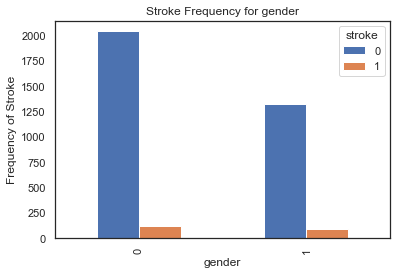

In [178]:
print("Positive: Male")
print("Negative: Female")
print()
bar_proportions(stroke_med,'gender')


#### HYPERTENSION

Totals per Variable: 
0    3119
1     446
Name: hypertension, dtype: int64


STROKE
30.69% of Stroke Patients are hypertension positive.
62 patients out of 202 total.


69.31% of Stroke Patients are hypertension negative.
140 patients out of 202 total.



NON-STROKE
11.42% of Non-Stroke Patients are hypertension positive.
384 patients out of 3363 total.


88.58% of Non-Stroke Patients are hypertension negative.
2979 patients out of 3363 total.


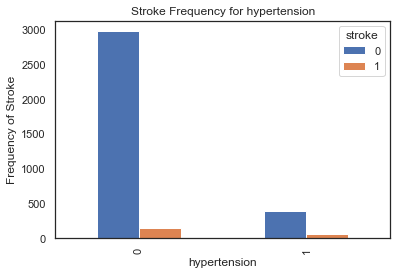

In [179]:
bar_proportions(stroke_med,'hypertension')


#### HEART DISEASE

Totals per Variable: 
0    3337
1     228
Name: heart_disease, dtype: int64


STROKE
19.31% of Stroke Patients are heart_disease positive.
39 patients out of 202 total.


80.69% of Stroke Patients are heart_disease negative.
163 patients out of 202 total.



NON-STROKE
5.62% of Non-Stroke Patients are heart_disease positive.
189 patients out of 3363 total.


94.38% of Non-Stroke Patients are heart_disease negative.
3174 patients out of 3363 total.


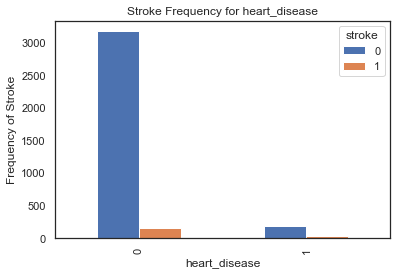

In [180]:
bar_proportions(stroke_med,'heart_disease')


#### EVER MARRIED


Totals per Variable: 
1    2710
0     855
Name: ever_married, dtype: int64


STROKE
89.6% of Stroke Patients are ever_married positive.
181 patients out of 202 total.


10.4% of Stroke Patients are ever_married negative.
21 patients out of 202 total.



NON-STROKE
75.2% of Non-Stroke Patients are ever_married positive.
2529 patients out of 3363 total.


24.8% of Non-Stroke Patients are ever_married negative.
834 patients out of 3363 total.


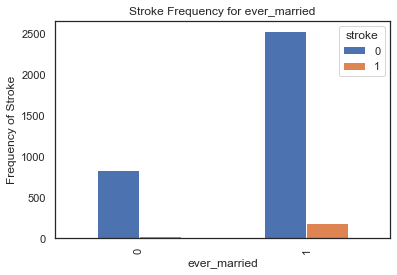

In [181]:
bar_proportions(stroke_med,'ever_married')


#### RESIDENCE TYPE

Positive: Urban
Negative: Rural

Totals per Variable: 
1    1814
0    1751
Name: Residence_type, dtype: int64


STROKE
52.48% of Stroke Patients are Residence_type positive.
106 patients out of 202 total.


47.52% of Stroke Patients are Residence_type negative.
96 patients out of 202 total.



NON-STROKE
50.79% of Non-Stroke Patients are Residence_type positive.
1708 patients out of 3363 total.


49.21% of Non-Stroke Patients are Residence_type negative.
1655 patients out of 3363 total.


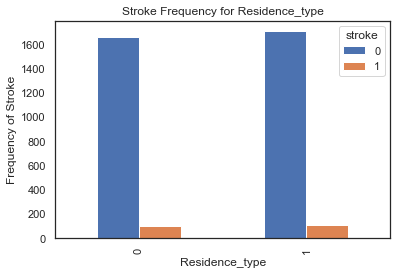

In [182]:
print("Positive: Urban")
print("Negative: Rural")
print()
bar_proportions(stroke_med,'Residence_type')

## 2.7 CATEGORICAL VARIABLES: Pie Chart & Calculations

In [183]:
def cat_pie_porportions1(df, col):
            
    # Totals
    print("Totals per Variable: ")
    print(df[col].value_counts())
    print()
    print()

    
    smoke_totals1=df[[col,'stroke']].loc[(df['stroke']==1)].groupby([col]).count()
    smoke_totals0=df[[col,'stroke']].loc[(df['stroke']==0)].groupby([col]).count()
    count1=(df['stroke']==1).sum()
    count0=(df['stroke']==0).sum()
    # % of Patients with Hypertension and Stroke
    x1=smoke_totals1/count1
    x0=smoke_totals0/count0
    print("Percentages of {} from all Stroke Observations".format(col))
    print(round(x1,2))
    print("Percentages of {} from all Non-Stroke Observations".format(col))
    print(round(x0,2))
    
    %matplotlib inline
    ax1=pd.crosstab(df[col],df['stroke']).plot(kind='bar')
    plt.title('Stroke Frequency for {}'.format(col))
    plt.xlabel(col)
    plt.ylabel('Frequency of Stroke')




Totals per Variable: 
never smoked       1892
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64


Percentages of smoking_status from all Stroke Observations
                 stroke
smoking_status         
formerly smoked    0.35
never smoked       0.45
smokes             0.21
Percentages of smoking_status from all Non-Stroke Observations
                 stroke
smoking_status         
formerly smoked    0.24
never smoked       0.54
smokes             0.22


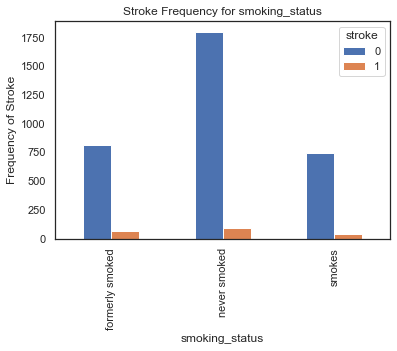

In [184]:
cat_pie_porportions1(stroke_med,'smoking_status')


Totals per Variable: 
Private          2284
Self-employed     663
Govt_job          535
children           69
Never_worked       14
Name: work_type, dtype: int64


Percentages of work_type from all Stroke Observations
               stroke
work_type            
Govt_job         0.12
Private          0.59
Self-employed    0.28
Percentages of work_type from all Non-Stroke Observations
               stroke
work_type            
Govt_job         0.15
Never_worked     0.00
Private          0.64
Self-employed    0.18
children         0.02


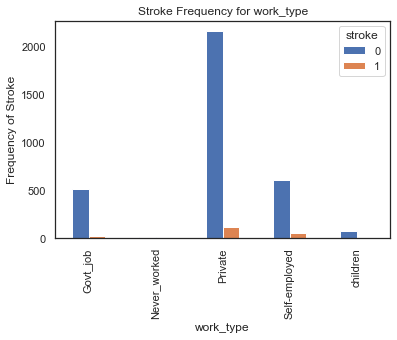

In [185]:
cat_pie_porportions1(stroke_med,'work_type')

### INSIGHTS: DATA EXPLORATION

### A) CONTINUOUS VARIABLES:

#### CHANGE IN MEDIAN:

#### 1.  AGE: The median Age increased the most at 47.92% of all continuous variables from 48 to 71 years old for stroke patients.
#### 2. GLUCOSE: The median Average Glucose Levels increased 15.75% from 92.07 mg/dL to 106.57 for stroke patients, 2nd most among continuous variables.
#### 3. BMI: The median BMI did not change for stroke patients.




### OUTLIERS:

#### 1. AGE: There are no age outliers among stroke and non-stroke observations.
#### 2. GLUCOSE: There are no glucose outliers among the 202 stroke observations, but there are 448 or 13.3% outliers among non-stroke observations.  The upper limit of the box plot is Upper Limit: 170.39, while the Max observation is 267.76.
#### 3. BMI: There are 12 or 5.9% BMI outliers among the 202 stroke observations, and 91 or 2.7% BMI outliers among 3364 non-stroke observations.  

#### CONCLUSION: Due to the low volume of Stroke=1 observations, all outliers will be included in the experiement.





### INTERQUARTILE RANGE

#### 1. AGE: The Interquartile Range (middle 50%) is 35% smaller for stroke observations, meaning less variance in age around the 71 year old median.

#### 2. GLUCOSE: The Interquartile Range (middle 50%) is nearly 400% larger for stroke observations, meaning a significant increase in variance. The min, Q1 and Median are all very similar for stroke vs non-stroke, but stroke Q3 is 90 points higher than the median, where non-stroke Q3 is only 22 points higher at 114.   

#### 3. BMI: The Interquartile Range (middle 50%) is 45% smaller for stroke observations, meaning a significant decrease in variance.



##@ RANGE DISTRIBUTION: 

#### 1. AGE: The range from max to min shrinks from 72 years for non-stroke, down to 50 years for stroke observations. All quartiles, minimums and maximumns are increased by nearly 20 years for stroke observations.

#### 2. GLUCOSE: The range from max to min is very simiar between stroke and non-stroke, meaning that the significant increase in the 3rd quartile for stroke points to any score above the non-stroke Q3 is more coorilated to stroke.

#### 3. BMI: Most of the stroke observations seem to be closer to the median than the non-stroke.



### STROKE DISTRIBUTION per UNIQUE RAW VALUES:
#### 1. AGE: a count bar graph per age clearly shows an uptick in stroke observatioons per age from 54 to 77 years old, and then a large increase from 78 years old and older.
#### 2. GLUCOSE: the avg_glucose_level is a continuous variable resulting in a large number of unique values and a vary chaotic raw data bar graph.  Glucose will benefit from binning, in the next step.
#### 3. BMI: Stroke observation frequency shoes roughly even distribution across the range of BMI values, however a large spike can be seen at the median, as that value was used to as a substitute for missing values.

### STROKE & NON STROKE DISTRIBUTION per BIN:
#### 1. AGE: Using 5 year bins for age, we observe a positively scewed distribution from 30 to 85 years old, with the peak between 75 and 80.  Among Non-stroke observations, we see a much more symmetrical normal distribution between 5 and 85 years old, with the peak between 50 and 55 years old.
#### 2. GLUCOSE: Among stroke bins, we see the first peak of 29 stroke observations between 70-80mg/dL, which then slopes down to a low between 150-160mg/dL, then spikes back up between 190-200 with 15 observations.  Non-Stroke follows a similar 2 peak path, except with the first peak between 80-90 much higher in frequency(578 observations), and the second peak between 200-210 at a relatively lower frequency with 80 observations.  The second peak might be key in using glucose level to predict stroke
#### 3. BMI: Both Stroke and non stroke bin graphs show very similar slightly negative skewed graphs.  Non-stroke is on a much larger scale even though distributions are similar.  

### B) QUALITATIVE BINARY VARIABLES: STROKE vs NON-STROKE

#### 1. GENDER: Both Stroke and Non-Stroke distributions come in around 60% Female and 40% male, however we do see a 3% increase to 42.5% in the male population when looking at stroke observations, vs non-stroke which males only have 29.3%.  
#### 2. HYPERTENSION: Stroke positive/hypertension positive observations showed a 20% increase for a total of 30.7%, compared to stroke negative/ hypertension positive.  Among stroke negative observations, hypertension positive shrinks down to 11.41% and non stroke/non hypertension grows to 88.6%. 
#### 3. HEART DISEASE: Similar to HYPERTENSION, we see a large increase in the % of stroke positive/heart disease positive at 19.31%, which is a significant increase versus stroke negative/heart disease positive observations which only apply to 5.6% of the non-stroke population.
#### 4.  MARRIAGE STATUS: We observe a 14% increase in the percentage of married observations when looking at the stroke positive population.  Stroke positive shows 89.6% married, 10.4% never married. Stroke Negative shows 75.1% married, 24.8% never married.  Marital stresses, sharing of unhealthy living habits or the increased likely hood of parenting stress could be the cause of this increase in stroke proportion.
#### 5. RESIDENCE TYPE: Stroke positive observations show just under a 2% increase in urban residence vs non-stroke.  Urban living increasing the likelyhood of stroke could be due to more access to processed foods, vehicle pollution or second hand smoke.

### C) QUALITATIVE NON-BINARY: Percentage & Count Breakdown of Stroke Positive Patients per Variable

#### 1. SMOKING STATUS: Even though we see a 10% flip flop between "formerly smoked" and "never smoked" observations when comparing Stroke vs Non-Stroke, the percentage of currently "smokes" almost stayed the same, decreasing 1% from 22% to 21% for stroke positive smokers.

#### 2. WORK TYPE: We see a 10% increase in "Private" employment among Stroke observations. This is the only increase and the biggest change among work types.  This might be attributed to the extra stresses that come with running your own company.

## 2.8 CONCLUSIONS: Variables that show significant change when Stroke=1:
#### Continuous: Age, Avg Glucose Level
#### Catagorical Binary: Hypertension, Heart Disease, Ever Married
#### Catagorical Non-Binary: Work Type

## 2.9 CHI SQUARED TEST: Categorical Variables

In [186]:
## ASSUMPTIONS: Independent Chi-Squared-Test
#### 1. Comparing 2 categorical variables.
#### 2. Sample is randomly drawn from population(no repeatable).
#### 3. Expected values in cells are at least 5

# Convert DF into contingency table
chi_df=stroke_med.iloc[:,[1,3,4,5,7,11]]

In [187]:
reject_null=[]
accept_null=[]
chi_squared=[0]
def chi_squared(df,cat,dependent,alpha):
    if cat != 'stroke':
        print('\033[1m'+"CHI-SQUARED TEST: {} vs {} - {}% Confidence Interval"'\033[0m'.format(cat,dependent,((1-alpha)*100)))    
        #Contingency Count Table: Observed Values
        conti=pd.crosstab(df[cat], df[dependent])
        # Find chi squared value, p-value, degrees of freedom
        c, p, dof, expected = chi2_contingency(conti)
        print()
        chisqt = pd.crosstab(df[cat], df[dependent], margins=True)
        print(chisqt)
        print()
        
        
        #contingency percent table - IF DESIRED
        conti_perc=pd.crosstab(df[cat], df[dependent], normalize='index')
        print(conti_perc)
        print()
        
        #Heatmap: Observed Values - IF DESIRED
        plt.figure(figsize=(6,4))
        sns.heatmap(conti, annot=True, cmap="YlGnBu",fmt='g')
        plt.show()
        print()
        
        
        # REMINDERS:
        # p-value <= alpha: Reject Null
        # X**2 value >= Critical look up value = Reject Null
        # 95% Conf Int = 1-.95 = 0.05 ALPHA
        # P-value(probabilitY): Prob that observed are chance alone, assuming null is true. aka % prob of NO RELATIONSHIP
        # Smaller the P-value: the more unlikely the observed data is
        # P <= A: Reject Null - "Result is stat sig" reasonabily sure something besides chance produced the observed
        # P> A: Fail to reject Null - Results are not stat sig, observed can be product of chance      
        # a = significance level = 0.05
        # df & A = Critical Value

        
        # Find chi squared value, p-value, degrees of freedom
        c, p, dof, expected = chi2_contingency(conti)
        print()
        print("DEGREES OF FREEDOM: "+str(round(dof,2)))
        print()
        print()
        print("ALPHA: {}".format(alpha))
        print("P-VALUE: "+str((p)))
        print()

        print()
        cv=scipy.stats.chi2.ppf(1-alpha, df=dof)
        print("CRITICAL VALUE: {}".format(cv))
        print("CHI-SQUARED VALUE: "+str(c))
        print()

        #convert expected values from scientific to deminal
        np.set_printoptions(formatter={'float_kind':'{:f}'.format})
        if len(df[cat].unique()) > 2:
            exp2=expected[1:3,:]
            print()
            print()
            print("EXPECTED VALUES: {} ".format(exp2))
            print()
            print("OBSERVED VALUES: {}".format(conti))
            print()
            print()
            print()
            print()
        else:
            exp2=expected
            print()
            print()
            print("EXPECTED VALUES: {} ".format(exp2))
            print()
            print("OBSERVED VALUES: {}".format(conti))
            print()
            print()
            print()
            print()

    #Assumption 1
        print("CHI SQUARED ASSUMPTIONS")
        if ((cat in ['gender','hypertension','heart_disease','ever_married','Residence_type']) & (dependent == 'stroke')):
            print("Assumption 1: Satisfied")
        else:
            print("Assumption 1: Not-Satisfied")


    #Assumption 2
        print('Assumption 2: Satisfied')


    #Assumption 3
        if (exp2.all()) > 5.00:
            print("Assumption 3: Not-Satisfied")
        else:
            print("Assumption 3: Satisfied")
        print()
        print()
        
        #test inference:
        if ((p<=alpha) & (c>=cv)):
            print("P-Value <= Alpha ---------------- TRUE") 
            print("Chi-Squared >= Critical Value --- TRUE")
            print()
            print()
            print('\033[1m'+"CONCLUSION: "+'\033[0m'+"REJECT the Null Hypothesis, based on a {}% confidence interval, {} and {} have a statistically significant relationship. ".format(((1-alpha)*100),cat,dependent))
            reject_null.append(cat)
            print()
            print()
            print("Fail To Reject Null: {}".format(accept_null))
            print("Reject Null: {}".format(reject_null))
        else:
            print("P-Value <= Alpha ---------------- FALSE") 
            print("Chi-Squared >= Critical Value --- FALSE")
            print()
            print()
            print('\033[1m'+"CONCLUSION: "+'\033[0m'+"FAIL to reject the Null Hypothesis. Based on a {}% confidence interval, we cannot conclude that {} and {} have a significant relationship.".format(((1-alpha)*100),cat,dependent)) 
            accept_null.append(cat)
            print()
            print()
            print("Fail To Reject Null: {}".format(accept_null))
            print("Reject Null: {}".format(reject_null))


CHI-SQUARED TEST: gender vs stroke - 95.0% Confidence Interval

stroke     0    1   All
gender                 
0       2042  116  2158
1       1321   86  1407
All     3363  202  3565

stroke         0         1
gender                    
0       0.946247  0.053753
1       0.938877  0.061123



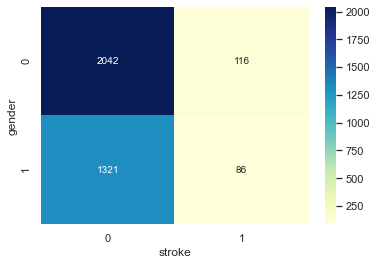



DEGREES OF FREEDOM: 1


ALPHA: 0.05
P-VALUE: 0.39191679619686126


CRITICAL VALUE: 3.841458820694124
CHI-SQUARED VALUE: 0.7329866887539882



EXPECTED VALUES: [[2035.723422 122.276578]
 [1327.276578 79.723422]] 

OBSERVED VALUES: stroke     0    1
gender           
0       2042  116
1       1321   86




CHI SQUARED ASSUMPTIONS
Assumption 1: Satisfied
Assumption 2: Satisfied
Assumption 3: Satisfied


P-Value <= Alpha ---------------- FALSE
Chi-Squared >= Critical Value --- FALSE


CONCLUSION: FAIL to reject the Null Hypothesis. Based on a 95.0% confidence interval, we cannot conclude that gender and stroke have a significant relationship.


Fail To Reject Null: ['gender']
Reject Null: []


In [188]:
chi_squared(stroke_med,'gender','stroke',0.05)

CHI-SQUARED TEST: hypertension vs stroke - 95.0% Confidence Interval

stroke           0    1   All
hypertension                 
0             2979  140  3119
1              384   62   446
All           3363  202  3565

stroke               0         1
hypertension                    
0             0.955114  0.044886
1             0.860987  0.139013



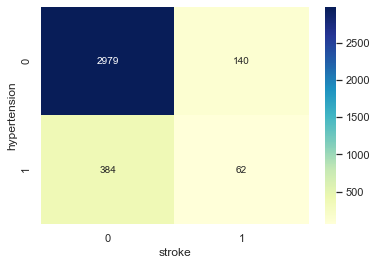



DEGREES OF FREEDOM: 1


ALPHA: 0.05
P-VALUE: 2.141984399861361e-15


CRITICAL VALUE: 3.841458820694124
CHI-SQUARED VALUE: 62.92987571683084



EXPECTED VALUES: [[2942.271248 176.728752]
 [420.728752 25.271248]] 

OBSERVED VALUES: stroke           0    1
hypertension           
0             2979  140
1              384   62




CHI SQUARED ASSUMPTIONS
Assumption 1: Satisfied
Assumption 2: Satisfied
Assumption 3: Satisfied


P-Value <= Alpha ---------------- TRUE
Chi-Squared >= Critical Value --- TRUE


CONCLUSION: REJECT the Null Hypothesis, based on a 95.0% confidence interval, hypertension and stroke have a statistically significant relationship. 


Fail To Reject Null: ['gender']
Reject Null: ['hypertension']


In [189]:
chi_squared(stroke_med,'hypertension','stroke',0.05)

CHI-SQUARED TEST: heart_disease vs stroke - 95.0% Confidence Interval

stroke            0    1   All
heart_disease                 
0              3174  163  3337
1               189   39   228
All            3363  202  3565

stroke                0         1
heart_disease                    
0              0.951154  0.048846
1              0.828947  0.171053



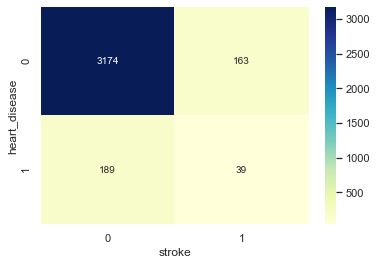



DEGREES OF FREEDOM: 1


ALPHA: 0.05
P-VALUE: 3.6200203014426576e-14


CRITICAL VALUE: 3.841458820694124
CHI-SQUARED VALUE: 57.364945561560674



EXPECTED VALUES: [[3147.918934 189.081066]
 [215.081066 12.918934]] 

OBSERVED VALUES: stroke            0    1
heart_disease           
0              3174  163
1               189   39




CHI SQUARED ASSUMPTIONS
Assumption 1: Satisfied
Assumption 2: Satisfied
Assumption 3: Satisfied


P-Value <= Alpha ---------------- TRUE
Chi-Squared >= Critical Value --- TRUE


CONCLUSION: REJECT the Null Hypothesis, based on a 95.0% confidence interval, heart_disease and stroke have a statistically significant relationship. 


Fail To Reject Null: ['gender']
Reject Null: ['hypertension', 'heart_disease']


In [190]:
chi_squared(stroke_med,'heart_disease','stroke', 0.05)

CHI-SQUARED TEST: ever_married vs stroke - 95.0% Confidence Interval

stroke           0    1   All
ever_married                 
0              834   21   855
1             2529  181  2710
All           3363  202  3565

stroke               0         1
ever_married                    
0             0.975439  0.024561
1             0.933210  0.066790



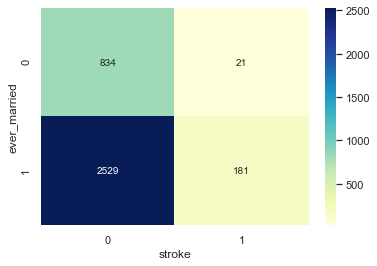



DEGREES OF FREEDOM: 1


ALPHA: 0.05
P-VALUE: 4.838049413996532e-06


CRITICAL VALUE: 3.841458820694124
CHI-SQUARED VALUE: 20.900354937003705



EXPECTED VALUES: [[806.553997 48.446003]
 [2556.446003 153.553997]] 

OBSERVED VALUES: stroke           0    1
ever_married           
0              834   21
1             2529  181




CHI SQUARED ASSUMPTIONS
Assumption 1: Satisfied
Assumption 2: Satisfied
Assumption 3: Satisfied


P-Value <= Alpha ---------------- TRUE
Chi-Squared >= Critical Value --- TRUE


CONCLUSION: REJECT the Null Hypothesis, based on a 95.0% confidence interval, ever_married and stroke have a statistically significant relationship. 


Fail To Reject Null: ['gender']
Reject Null: ['hypertension', 'heart_disease', 'ever_married']


In [191]:
chi_squared(stroke_med,'ever_married','stroke', 0.05)

CHI-SQUARED TEST: Residence_type vs stroke - 95.0% Confidence Interval

stroke             0    1   All
Residence_type                 
0               1655   96  1751
1               1708  106  1814
All             3363  202  3565

stroke                 0         1
Residence_type                    
0               0.945174  0.054826
1               0.941566  0.058434



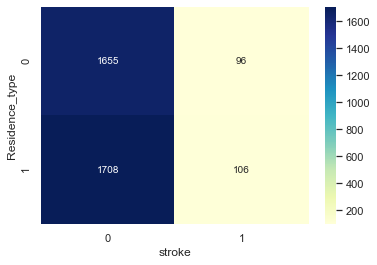



DEGREES OF FREEDOM: 1


ALPHA: 0.05
P-VALUE: 0.6939922918664747


CRITICAL VALUE: 3.841458820694124
CHI-SQUARED VALUE: 0.15479741960775273



EXPECTED VALUES: [[1651.784853 99.215147]
 [1711.215147 102.784853]] 

OBSERVED VALUES: stroke             0    1
Residence_type           
0               1655   96
1               1708  106




CHI SQUARED ASSUMPTIONS
Assumption 1: Satisfied
Assumption 2: Satisfied
Assumption 3: Satisfied


P-Value <= Alpha ---------------- FALSE
Chi-Squared >= Critical Value --- FALSE


CONCLUSION: FAIL to reject the Null Hypothesis. Based on a 95.0% confidence interval, we cannot conclude that Residence_type and stroke have a significant relationship.


Fail To Reject Null: ['gender', 'Residence_type']
Reject Null: ['hypertension', 'heart_disease', 'ever_married']


In [192]:
chi_squared(stroke_med,'Residence_type','stroke', 0.05)

CHI-SQUARED TEST: smoking_status vs stroke - 95.0% Confidence Interval

stroke              0    1   All
smoking_status                  
formerly smoked   814   70   884
never smoked     1802   90  1892
smokes            747   42   789
All              3363  202  3565

stroke                  0         1
smoking_status                     
formerly smoked  0.920814  0.079186
never smoked     0.952431  0.047569
smokes           0.946768  0.053232



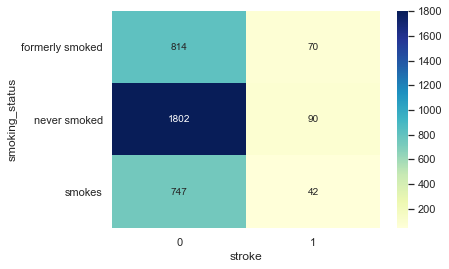



DEGREES OF FREEDOM: 2


ALPHA: 0.05
P-VALUE: 0.003197753320128626


CRITICAL VALUE: 5.991464547107979
CHI-SQUARED VALUE: 11.490613606430163



EXPECTED VALUES: [[1784.795512 107.204488]
 [744.293689 44.706311]] 

OBSERVED VALUES: stroke              0   1
smoking_status           
formerly smoked   814  70
never smoked     1802  90
smokes            747  42




CHI SQUARED ASSUMPTIONS
Assumption 1: Not-Satisfied
Assumption 2: Satisfied
Assumption 3: Satisfied


P-Value <= Alpha ---------------- TRUE
Chi-Squared >= Critical Value --- TRUE


CONCLUSION: REJECT the Null Hypothesis, based on a 95.0% confidence interval, smoking_status and stroke have a statistically significant relationship. 


Fail To Reject Null: ['gender', 'Residence_type']
Reject Null: ['hypertension', 'heart_disease', 'ever_married', 'smoking_status']


In [193]:
chi_squared(stroke_med,'smoking_status','stroke', 0.05)

CHI-SQUARED TEST: work_type vs stroke - 95.0% Confidence Interval

stroke            0    1   All
work_type                     
Govt_job        510   25   535
Never_worked     14    0    14
Private        2164  120  2284
Self-employed   606   57   663
children         69    0    69
All            3363  202  3565

stroke                0         1
work_type                        
Govt_job       0.953271  0.046729
Never_worked   1.000000  0.000000
Private        0.947461  0.052539
Self-employed  0.914027  0.085973
children       1.000000  0.000000



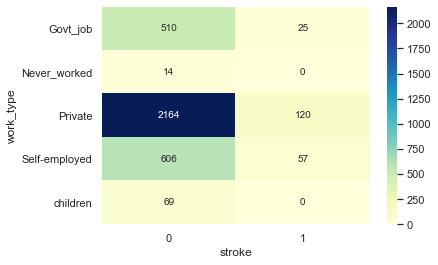



DEGREES OF FREEDOM: 4


ALPHA: 0.05
P-VALUE: 0.0016483508577038448


CRITICAL VALUE: 9.487729036781154
CHI-SQUARED VALUE: 17.35563250645182



EXPECTED VALUES: [[13.206732 0.793268]
 [2154.584011 129.415989]] 

OBSERVED VALUES: stroke            0    1
work_type               
Govt_job        510   25
Never_worked     14    0
Private        2164  120
Self-employed   606   57
children         69    0




CHI SQUARED ASSUMPTIONS
Assumption 1: Not-Satisfied
Assumption 2: Satisfied
Assumption 3: Satisfied


P-Value <= Alpha ---------------- TRUE
Chi-Squared >= Critical Value --- TRUE


CONCLUSION: REJECT the Null Hypothesis, based on a 95.0% confidence interval, work_type and stroke have a statistically significant relationship. 


Fail To Reject Null: ['gender', 'Residence_type']
Reject Null: ['hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'work_type']


In [194]:
chi_squared(stroke_med,'work_type','stroke',0.05)

## 2.10 T-TEST: Continuous Variables

In [195]:
# B) Numerical Variables vs Stroke(Catagorical): T-Test

def t_test_groups(df,cont,binary,alpha):
    
    alpha=alpha
    #print title
    print(('\033[1m'+"T-TEST: {} vs {} - {}% Confidence Interval"+'\033[0m').format(binary,cont,((1-alpha)*100)))    
       
    #Separate the 2 groups of continuous variable by each value in binary.
    a=df[(df[binary]== 1)][cont]
    b=df[(df[binary]== 0)][cont]
    print()
    
    
    #print Hypothesis'
    print("Null: The means of both populations are equal")
    print("Alternative: The means of both populations are not equal")    
    print()
    print()
    
    #T-test
    tStat, p = stats.ttest_ind(a, b, equal_var = False) #run independent sample T-Test
    print("P-Value:{0} T-Statistic:{1}".format(p,tStat)) #print the P-Value and the T-Statistic
    print()
    if (p<=alpha):
        print("P-Value <= Alpha ---------------- TRUE") 
        print()
        print()
        print('\033[1m'+"CONCLUSION: "+'\033[0m'+"REJECT the Null Hypothesis. Based on a {}% confidence interval, {} positive {} observations have a statistically significant difference in mean than for {} negative observations. ".format(((1-alpha)*100),binary,cont,binary))
        reject_null.append(cont)
        print()
        print()
        print("Accept Null: {}".format(accept_null))
        print("Reject Null: {}".format(reject_null))    
    else:
        print("P-Value <= Alpha ---------------- FALSE") 
        print("Chi-Squared >= Critical Value --- FALSE")
        print()
        print()
        print('\033[1m'+"CONCLUSION: "+'\033[0m'+"FAIL to reject the Null Hypothesis. Based on a {}% confidence interval, we cannot conclude that {} positive {} observations have a statistically significant difference in mean than for {} negative observations. ".format(((1-alpha)*100),binary,cont,binary))
        accept_null.append(cont)
        print()
        print()
        print("Accept Null: {}".format(accept_null))
        print("Reject Null: {}".format(reject_null))



In [196]:
t_test_groups(stroke_med,'age','stroke',0.05)

T-TEST: stroke vs age - 95.0% Confidence Interval

Null: The means of both populations are equal
Alternative: The means of both populations are not equal


P-Value:2.6361489409549117e-65 T-Statistic:23.051445501455497

P-Value <= Alpha ---------------- TRUE


CONCLUSION: REJECT the Null Hypothesis. Based on a 95.0% confidence interval, stroke positive age observations have a statistically significant difference in mean than for stroke negative observations. 


Accept Null: ['gender', 'Residence_type']
Reject Null: ['hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'work_type', 'age']


In [197]:
t_test_groups(stroke_med,'avg_glucose_level','stroke',0.05)

T-TEST: stroke vs avg_glucose_level - 95.0% Confidence Interval

Null: The means of both populations are equal
Alternative: The means of both populations are not equal


P-Value:9.718750282976495e-09 T-Statistic:5.970001486683919

P-Value <= Alpha ---------------- TRUE


CONCLUSION: REJECT the Null Hypothesis. Based on a 95.0% confidence interval, stroke positive avg_glucose_level observations have a statistically significant difference in mean than for stroke negative observations. 


Accept Null: ['gender', 'Residence_type']
Reject Null: ['hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'work_type', 'age', 'avg_glucose_level']


In [198]:
t_test_groups(stroke_med,'bmi','stroke',0.05)
 

T-TEST: stroke vs bmi - 95.0% Confidence Interval

Null: The means of both populations are equal
Alternative: The means of both populations are not equal


P-Value:0.5670410242351578 T-Statistic:0.5732150704713735

P-Value <= Alpha ---------------- FALSE
Chi-Squared >= Critical Value --- FALSE


CONCLUSION: FAIL to reject the Null Hypothesis. Based on a 95.0% confidence interval, we cannot conclude that stroke positive bmi observations have a statistically significant difference in mean than for stroke negative observations. 


Accept Null: ['gender', 'Residence_type', 'bmi']
Reject Null: ['hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'work_type', 'age', 'avg_glucose_level']


## 2.11 ASSUMPTIONS: Independent T-Test
#### 1. The independent variable (IV) is categorical with at least two levels (groups)
#### 2. The dependent variable (DV) is continuous which is measured on an interval or ratio scale
#### 3. The distribution of the two groups should follow the normal distribution
#### 4. The variances between the two groups are equal

    


In [220]:
def t_assumptions(df,cont,dep, alpha_decimal):
    yes=df[df[dep]==1]
    no =df[df[dep]==0]
    print(cont)
    print()
    #Assumption 1:
    if len(df[dep].unique())>=2:
        print("Assumption 1: Pass")
    else:
        print("Assumption 1: Does Not Pass")
    print()
    #Assumption 2:
    if cont in ['age','bmi','avg_glucose_level']:
        print("Assumption 2: Pass")
    else:
        print("Assumption 2: Does Not Pass")
    print()
    #Assumption 3: Normality(Shapiro-Wilk Test)
    shapiro,p3 = stats.shapiro(df[cont])
    if p3 <= alpha_decimal:
        print("Assumption 3: Does Not Pass. There is NOT normality. P-value = {}. Reject null hypothesis at the α ={} level of significance. There is sufficent evidence to conclude that {} not normally distributed.".format(p3,alpha_decimal, cont))
    else:
        print("Assumption 3: Pass. There is normality. P-value = {}. Fail to reject null hypothesis at the α ={} level of significance. There is not sufficent evidence to conclude that {} not normally distributed.".format(p3,alpha_decimal, cont))
    #plot histogram for normality visual
    df[cont].plot(kind="hist", title= "Versicolor Sepal Width", color="green")
    plt.xlabel(cont)
    plt.savefig(cont)
    print()          

    #Assumption 4(Levene Test): Null=groups have equal pop variance
    stat,p4 = (stats.levene(yes[cont],no[cont]))
    if p4 <= alpha_decimal:
        print("Assumption 4: Does Not Pass. There is NOT homogeneity of variance. P-value = {}. Reject null hypothesis at the α ={} level of significance. There is sufficent evidence to conclude the {} vs Non-{} samples do not have equal variances.".format(p4,alpha_decimal, dep,dep))
    else:
        print("Assumption 4: Pass. There is homogeneity of variance. P-value = {}. Fail to reject null hypothesis at the α ={} level of significance. There is not sufficent evidence to conclude the {} vs Non-{} samples do not have equal variances.".format(p4,alpha_decimal, dep,dep))
              


age

Assumption 1: Pass

Assumption 2: Pass

Assumption 3: Does Not Pass. There is NOT normality. P-value = 1.5288740640765413e-25. Reject null hypothesis at the α =0.05 level of significance. There is sufficent evidence to conclude that age not normally distributed.

Assumption 4: Does Not Pass. There is NOT homogeneity of variance. P-value = 2.70370206471485e-16. Reject null hypothesis at the α =0.05 level of significance. There is sufficent evidence to conclude the stroke vs Non-stroke samples do not have equal variances.


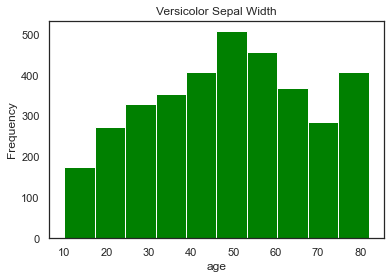

In [200]:
t_assumptions(stroke_med,'age','stroke',0.05)

bmi

Assumption 1: Pass

Assumption 2: Pass

Assumption 3: Does Not Pass. There is NOT normality. P-value = 1.2601990538796752e-36. Reject null hypothesis at the α =0.05 level of significance. There is sufficent evidence to conclude that bmi not normally distributed.

Assumption 4: Does Not Pass. There is NOT homogeneity of variance. P-value = 0.004442871601966596. Reject null hypothesis at the α =0.05 level of significance. There is sufficent evidence to conclude the stroke vs Non-stroke samples do not have equal variances.


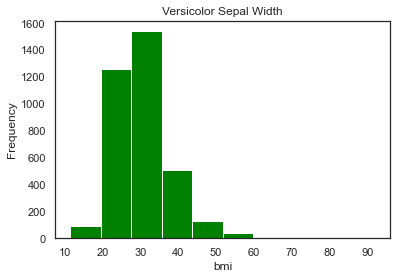

In [201]:
t_assumptions(stroke_med,'bmi','stroke',0.05)

avg_glucose_level

Assumption 1: Pass

Assumption 2: Pass

Assumption 3: Does Not Pass. There is NOT normality. P-value = 0.0. Reject null hypothesis at the α =0.05 level of significance. There is sufficent evidence to conclude that avg_glucose_level not normally distributed.

Assumption 4: Does Not Pass. There is NOT homogeneity of variance. P-value = 9.748447413139606e-15. Reject null hypothesis at the α =0.05 level of significance. There is sufficent evidence to conclude the stroke vs Non-stroke samples do not have equal variances.


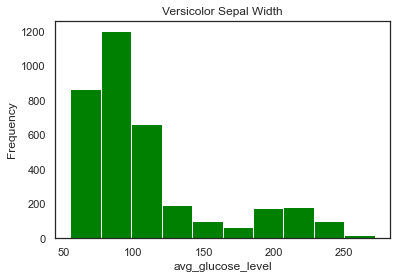

In [202]:
 t_assumptions(stroke_med,'avg_glucose_level','stroke',0.05)

In [203]:
print("Fail to Reject Null: {}".format(accept_null))
print()
print("These variables do not have a statistically significant association to Stroke.")
print("However, we will proceed to include all in the Logistic Regression.")
print("Even if a single variable has little individual effect on the dependant variable, effects may exponentially increase when") 
print("interacting with other independent variables. This tendency is low but we must explore all independent variables to ensure")
print("totality in analysis.")
print()
print()
print("Reject Null: {}".format(reject_null))
print()
print("These variables have a statistically significant association to Stroke.")
print()
 


Fail to Reject Null: ['gender', 'Residence_type', 'bmi']

These variables do not have a statistically significant association to Stroke.
However, we will proceed to include all in the Logistic Regression.
Even if a single variable has little individual effect on the dependant variable, effects may exponentially increase when
interacting with other independent variables. This tendency is low but we must explore all independent variables to ensure
totality in analysis.


Reject Null: ['hypertension', 'heart_disease', 'ever_married', 'smoking_status', 'work_type', 'age', 'avg_glucose_level']

These variables have a statistically significant association to Stroke.



### Since Stroke is a binary outcome, we will employ a Logistic Regression`"
  
## Assumptions of Logistic Regression:
#### 1. Data is free of missing values - SATISFIED
#### 2. The dependent variable is binary or ordinal - SATISFIED
#### 3. All predictors are independent of each other - SATISFIED
#### 4. There are atleast 50 observations per predictor variable - SATISFIED"
  


# 3. LOGISTIC REGRESSION MODEL PRODUCTION

In [16]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [17]:
# DUMMY TRANSFORMATIONS FOR NON-BINARY CATEGORICAL: work_type, smoking_status
dum_pre=pd.get_dummies(stroke_med, columns=['smoking_status'])
DUM=pd.get_dummies(dum_pre, columns=['work_type'])
dum_array=DUM.to_numpy()

# Renaming dummie columns
DUM.rename(columns={'smoking_status_formerly smoked':'formerly_smoked','smoking_status_never smoked':'never_smoked','smoking_status_smokes':'smokes','work_type_Self-employed':'work_type_self'},inplace=True)
DUM.rename(columns={DUM.columns[16]:'work_type_self'})
print(dum_array)

DUM=DUM.drop(['stroke','id'],axis=1)
y=stroke_med.iloc[:,11:12]

[[9.0460e+03 1.0000e+00 6.7000e+01 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [5.1676e+04 0.0000e+00 6.1000e+01 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [3.1112e+04 1.0000e+00 8.0000e+01 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [4.4873e+04 0.0000e+00 8.1000e+01 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.9723e+04 0.0000e+00 3.5000e+01 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [3.7544e+04 1.0000e+00 5.1000e+01 ... 1.0000e+00 0.0000e+00 0.0000e+00]]


## 3.1 Data Splitting

In [18]:
# 80% train/20% test 

X_train, X_test, y_train, y_test = train_test_split(DUM, y, test_size = 0.2, random_state = 22)



In [19]:
## SMOTE Conversion
### NOTE: Utilizing SMOTE() in order to oversample the "stroke=1" minority.  This is an industry recognized method to rectify over-fitting due random oversampling.
smote = SMOTE(random_state = 22)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, y_train)

## 3.2 Building Classification Model

In [20]:
lg = LogisticRegression(random_state = 22,solver='lbfgs',max_iter=6000)
lg_fit=lg.fit(X_train_balanced, Y_train_balanced)
y_pred = lg_fit.predict(X_test)
X_train_balanced

C:\Users\tfuji\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,formerly_smoked,never_smoked,smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_self,work_type_children
0,1,20.000000,0,0,0,0,75.900000,32.200000,0,1,0,0,0,1,0,0
1,0,31.000000,0,0,1,0,69.260000,21.800000,1,0,0,0,0,1,0,0
2,0,48.000000,0,0,1,1,74.110000,20.500000,0,1,0,0,0,1,0,0
3,0,20.000000,0,0,0,1,66.550000,26.900000,0,0,1,0,0,1,0,0
4,1,67.000000,0,0,1,1,97.340000,28.900000,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0,77.422610,0,0,1,0,124.797724,30.618171,0,1,0,0,0,0,0,0
5396,0,57.292504,0,0,1,0,92.383949,26.602971,0,0,0,0,0,0,0,0
5397,0,52.350557,0,0,1,1,177.730080,29.910254,0,0,0,0,0,0,0,0
5398,0,71.002099,0,0,1,0,263.319139,38.698367,0,0,0,0,0,0,0,0


## 3.3 CONFUSION MATRIX

Confusion Matrix
[[630  33]
 [ 41   9]]

Confusion Matrix Percentages
[[0.95022624 0.04977376]
 [0.82       0.18      ]]



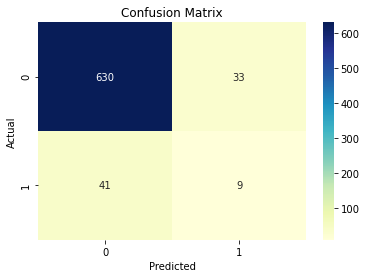

In [21]:
# Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
print(cm)
print()
    
    
#Confusion Matrix Percentages
print('Confusion Matrix Percentages')
cm_percents = cm/cm.sum(axis=1).reshape(-1,1)
print(cm_percents)
 
    
def plot_confusion(cm,classes=None, title="Confusion Matrix"):
    sns.heatmap(cm, annot=True, cmap="YlGnBu",fmt='g')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plot_confusion(cm, classes=lg.classes_, title="Confusion Matrix")
print() 
   

## 3.4 CLASSIFICATION REPORT

In [22]:
# CLASSIFICATION REPORT
## Precision: TP/(TP + FP) - Vertical calc - How effective in avoiding mistakes?
## Recall: TP/(TP+FN) - Horizontal calc - How many of observed cases are correctly predicted
## NOTE: If priority is detection, then minimizing FN is important: focus on recall
## F1-Score: 2*(Prec*Recall)/(Prec+Recall) Good for imbalanced dataset. Takes into account both P and R, harmonic mean of Recall and Precision. 
## Support is the number of true response samples in that class
print(classification_report(y_test, y_pred))    


              precision    recall  f1-score   support

           0       0.94      0.95      0.94       663
           1       0.21      0.18      0.20        50

    accuracy                           0.90       713
   macro avg       0.58      0.57      0.57       713
weighted avg       0.89      0.90      0.89       713



In [23]:
 
# Calc False Positives etc...
FN = cm.sum(axis=0) - np.diag(cm)
FP = cm.sum(axis=1) - np.diag(cm)
TN = np.diag(cm)
TP = cm.sum() - (FP+ FN + TN)
print("False Positive: ",FP)
print("False Negative: ",FN)
print("True Positive: ",TP)
print("True Negative: ",TN)
    
# True Positive Rate
TPR= TP/(TP+FN)
print("The True Positive Rate is: ",TPR)
    
# Total Averages
print("The average TPR is: ",TPR.sum()/2)
    
# Precision or Positive Predictive Value - 1st= % correct for stroke=0, 2nd= % correct for stroke=1
PPV=TP/(TP+FP)
print("The Precision is: ", PPV)
    
# False Positive Rate or False Alarm Rate - 
FPR = FP/(FP + TN)
print("The False Postive Rate is: ", FPR)
    
# False Negative
FNR = FN/(FN+TP)
print("FNR",FNR)


False Positive:  [33 41]
False Negative:  [41 33]
True Positive:  [  9 630]
True Negative:  [630   9]
The True Positive Rate is:  [0.18       0.95022624]
The average TPR is:  0.5651131221719456
The Precision is:  [0.21428571 0.93889717]
The False Postive Rate is:  [0.04977376 0.82      ]
FNR [0.82       0.04977376]


### 3.5 Precision Recall Curve

Logistic: f1=0.202 auc=0.182


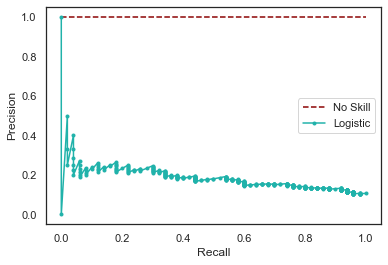

In [227]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


#### ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
#### Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
#### ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

# keep probabilities for the positive outcome only
lr_probs = pred_proba_t[:, 1]
# predict class values
yhat = lg_fit.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color='darkred')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic', color='lightseagreen')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## 3.6 COEFFICENTS & ODDS RATIO

In [257]:
## OPTION 1: LOGIT SUMMARY, No Constant or with ADD_CONSTANT

# WITHOUT CONSTANT
logreg6 = sm.Logit(Y_train_balanced, X_train_balanced)
results=logreg6.fit()
print(results.summary())




logit = sm.Logit(Y_train_balanced,X_train_balanced)
coeff=logit.fit().params


coeff=pd.DataFrame(coeff)
coeff=coeff.rename(columns={0: "Coefficent"})
coeff=coeff.sort_values(by='Coefficent', ascending=False)


# ADDING ODDS RATIO
import math
odds_change=[]
for row in coeff.itertuples():
    odds=float((math.exp(row[1])))
    odds_change.append(odds)


dict2={'index':coeff.index, 'Coefficent':coeff.iloc[:,0], 'Odds Ratio':odds_change}
df2=pd.DataFrame(dict2)
df2=df2.set_index('index')
df2

         Current function value: 0.202925
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 5400
Model:                          Logit   Df Residuals:                     5384
Method:                           MLE   Df Model:                           15
Date:                Thu, 15 Apr 2021   Pseudo R-squ.:                  0.7072
Time:                        11:11:52   Log-Likelihood:                -1095.8
converged:                      False   LL-Null:                       -3743.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
gender                    -0.8432      0.124     -6.796      0.000      -1.086      -0.600
age                        0.

C:\Users\tfuji\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\tfuji\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Coefficent,Odds Ratio
index,,
age,0.115497,1.122431e+00
bmi,0.057280,1.058953e+00
avg_glucose_level,0.007004,1.007029e+00
hypertension,-0.515130,5.974232e-01
heart_disease,-0.524061,5.921110e-01
ever_married,-0.624910,5.353098e-01
Residence_type,-0.769141,4.634108e-01
gender,-0.843241,4.303135e-01
smokes,-4.488028,1.124279e-02


## 3.7 MODEL EVALUATION & ACCURACY SCORING

In [258]:
#accuracy report
acc=accuracy_score(y_test, y_pred)
print("Accuracy Score: {}%".format(round(acc*100,2)))
print()
print()

# Testing Accuracy
lg_testing_score = lg_fit.score(X_test,y_test)
print("Logistic Regression Testing Score(Mean Accuracy % for Test Sample)): {}%".format(round(lg_testing_score*100,2)))


# Training Accuracy
lg_training_score = lg_fit.score(X_train_balanced,Y_train_balanced)
print("Logistic Regression Training Score(Mean Accuracy % for Test Sample)): {}%".format(round(lg_training_score*100,3)))
print()
# Log Loss testing
pred_proba_t = lg_fit.predict_proba(X_test)
print("Log Loss on Testing Dataset is: {}%".format(round(log_loss(y_test, pred_proba_t)*100,2)))


Accuracy Score: 90.04%


Logistic Regression Testing Score(Mean Accuracy % for Test Sample)): 90.04%
Logistic Regression Training Score(Mean Accuracy % for Test Sample)): 90.926%

Log Loss on Testing Dataset is: 25.44%


## 3.8 FINAL MODEL

In [259]:
# FINAL MODEL    
lg = LogisticRegression(random_state = 22,solver='lbfgs',max_iter=6000,C=1e9)
lg_fit=lg.fit(X_train_balanced, Y_train_balanced)
y_pred = lg_fit.predict(X_test)

# Testing Accuracy
lg_testing_score = lg_fit.score(X_test,y_test)
print("Logistic Regression Testing Score(Mean Accuracy % for Test Sample)): {}%".format(round(lg_testing_score*100,4)))

# Log Loss testing
pred_proba_t = lg_fit.predict_proba(X_test)
print("Log Loss on Testing Dataset is: {}%".format(round(log_loss(y_test, pred_proba_t)*100,2)))
print(pred_proba_t[0:5])




C:\Users\tfuji\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Logistic Regression Testing Score(Mean Accuracy % for Test Sample)): 90.0421%
Log Loss on Testing Dataset is: 25.44%
[[0.631800 0.368200]
 [0.931398 0.068602]
 [0.849299 0.150701]
 [0.986659 0.013341]
 [0.977730 0.022270]]


Insights
## 1. We will build a highly accurate predictive generalized model to help anticipate the on-set of stroke in a persons life time
## 2. From the given data set we will be identifying the significant and in-significant variables in predicting stroke likelyhood.
## 3. Variable significance will be judged univariantly based upon comparing the p-values to our alpha value(0.05/95%).
## 4. The final model will be able to accurately predict whether stroke or non-stroke is likely to occur in the lifetime.
## 5. Smoking Status, Work Type, Residence Type, Heart Disease and Marriage status are the 5 most influencial variables for stroke prediction
## 6. the slope coefficient is interpreted as the rate of change in the "log odds" as X changes. 